Universidad Galileo  
Maestría en Data Science  
Statistical Learning I
Sección U  


   # **Tarea 4: Fashion-MNIST**


<p style="text-align: right;">
Henry Giovanni<br/>
Barrientos García<br/>
21001538<br/>
Guatemala, 19 de junio de 2022<br/>
</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow.compat.v1 as tf
from tensorflow import keras
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from random import sample 
%reload_ext tensorboard
tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


AttributeError: module 'tensorflow._api.v1.compat.v1.compat' has no attribute 'v1'

## Carga de datos

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

Fashion-MNIST es un conjunto de datos de imágenes de artículos de Zalando, que consta de un conjunto de entrenamiento de 60 000 ejemplos y un conjunto de prueba de 10 000 ejemplos. Cada ejemplo es una imagen en escala de grises de 28x28, asociada con una etiqueta de 10 clases. Zalando tiene la intención de que Fashion-MNIST sirva como un reemplazo directo del conjunto de datos MNIST original para comparar algoritmos de aprendizaje automático. Comparte el mismo tamaño de imagen y estructura de las divisiones de entrenamiento y prueba.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imágenes
Las imágenes son objetos de tipo Numpy Array de 28x28, el color de cada pixel esta entre los valores de 0 a 255.

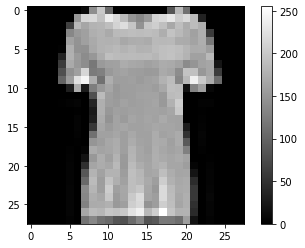

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Etiquetas

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

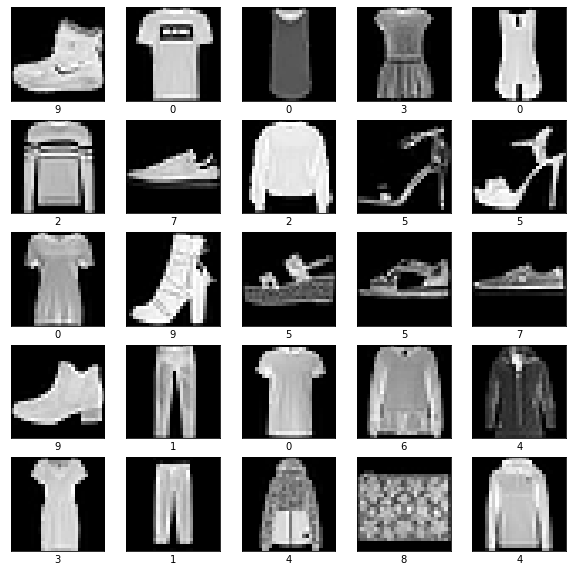

In [6]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Instrucciones

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Preparación de los datos

In [7]:
diccionarioLabels =  {0:"T-shirt/top", 1: "Trouser",
                      2: "Pullover", 3: "Dress",
                      4: "Coat", 5: "Sandal",
                      6: "Shirt", 7: "Sneaker",
                      8: "Bag", 9: "Ankle boot"}

# One hot encoding para los datos de entrenamiento
ohe_train = OneHotEncoder(categories = 'auto')
ohe_train.fit(train_labels.reshape(-1, 1))
ohe_labels_train = ohe_train.transform(train_labels.reshape(-1, 1)).toarray()

# One hot encoding a los datos de prueba
ohe_test = OneHotEncoder(categories = 'auto')
ohe_test.fit(test_labels.reshape(-1, 1))
ohe_labels_test = ohe_test.transform(test_labels.reshape(-1, 1)).toarray()

In [8]:
# Convirtiendo el array de imágenes al shape de tensor en modo RAW (crudo)
def toTensorShapeRaw(imgs):
    imgs_shaped = imgs.reshape(-1, 28 * 28)
    # Agregamos un 1 para complementar el tensor y que sirva para los cálculos más adelante
    imgs_shaped = np.insert(imgs_shaped, 0, np.ones(len(imgs_shaped)), axis=1).astype(np.float32)
    return imgs_shaped

# Convirtiendo el array de imágenes al shape de tensor en modo RAW (crudo)
def toTensorShapeNormalized(imgs):
    imgs_shaped = imgs.reshape(-1, 28 * 28)
    # Normalización del vector
    imgs_shaped = normalize(imgs_shaped, norm = 'max', axis = 1)
    imgs_shaped = np.insert(imgs_shaped, 0, np.ones(len(imgs_shaped)), axis=1).astype(np.float32)
    return imgs_shaped

# Convirtiendo el array de imágenes al shape de tensor en modo RAW (crudo)
def toTensorShapeScaled(imgs):
    imgs_shaped = imgs.reshape(-1, 28 * 28)
    imgs_shaped = scale(imgs_shaped)
    imgs_shaped = np.insert(imgs_shaped, 0, np.ones(len(imgs_shaped)), axis=1).astype(np.float32)
    return imgs_shaped

In [9]:
# X listos para usar en el modelo de regresión logística
xtrain_raw = toTensorShapeRaw(train_images)
xtest_raw = toTensorShapeRaw(test_images)
xtrain_nor = toTensorShapeNormalized(train_images)
xtest_nor = toTensorShapeNormalized(test_images)
xtrain_sca = toTensorShapeNormalized(train_images)
xtest_sca = toTensorShapeNormalized(test_images)

## Modelo de regresión logística con Tensor Flow

In [10]:
# MRL = modelo de regresión logística
class MRL:
    def __init__(self, x, labels):
        self.parametros = tf.get_variable("parametros", dtype = tf.float32, 
                                          shape = [xtrain_raw.shape[1], labels.shape[1]],
                                          initializer = tf.zeros_initializer())

    def get_prediction(self, x):
        return tf.nn.softmax(tf.matmul(x, self.parametros))

    def get_accuracy(self, predictions, labels):
        a = tf.equal(tf.argmax(predictions,1), tf.argmax(labels,1))
        a = tf.dtypes.cast(a, tf.int32)
        a = tf.divide(tf.reduce_sum(a), tf.shape(labels)[0])
        return a
    
    def get_logits(self, x):
        return tf.matmul(x, self.parametros)

    def gradient_descent(self, xtrain, labels_train, xtest, labels_test, lr):
        
        with tf.name_scope("error"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels_train, logits = self.get_logits(xtrain)))
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = labels_test, logits = self.get_logits(xtest)))
            test_error_summary = tf.summary.scalar("TestError", test_error)
            
        with tf.name_scope("accuracy"):
            train_accuracy = self.get_accuracy(self.get_prediction(xtrain), labels_train)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            test_accuracy = self.get_accuracy(self.get_prediction(xtest), labels_test)
            test_accuracy_summary = tf.summary.scalar("TestAccuracy", test_accuracy)
        
        # Determinar nuevos parámetros con Gradient descent
        gradiente = tf.gradients(train_error, [self.parametros])
        new_parametros = tf.assign(self.parametros, self.parametros - lr * gradiente[0])
        return new_parametros, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary

In [11]:
# Funcion de entrenamiento
def training_model(xtrain, xtest, labels_train, labels_test, lr, epochs, printl):
    # Ubicación para guardar logs de experimentos
    directory = './logs/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs)
    
    graph = tf.Graph()
    with graph.as_default():
        
        # Tensores input
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,xtrain.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")
        with tf.name_scope("test_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [xtest.shape[0], xtest.shape[1]], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_test")
        
        mrl = MRL(xtrain, ohe_labels_train)
        nuevos_parametros = mrl.gradient_descent(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Almacenamiento de datos para tensorboard
        tboardW = tf.summary.FileWriter(directory, graph)
        
        # Parámetros para batch
        batch_size = 32
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        # Ejecución del grafo
        with tf.train.MonitoredSession() as session:
            for i in range(total_steps + 1):
                # Valores para Mini batch
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                # Datos del bach actual
                batch_data = xtrain[offset:(offset + batch_size),]
                # Selecccionando las labels del bach actual
                batch_labels = labels_train[offset:(offset + batch_size),]
                
                # Configuracion de valores para los tensores input
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:xtest, tensor_labels_test:labels_test}
                
                # Entrenamiento del modelo para cálculo de los nuevos parámetros
                entrenamiento = session.run(nuevos_parametros, feed_dict = feed_dict)
                
                if (i % printl == 0):
                    parametros = session.run(mrl.parametros, feed_dict = feed_dict)
                    # Almacenamiento de tensorboard
                    tboardW.add_summary(entrenamiento[5], i)
                    tboardW.add_summary(entrenamiento[6], i)
                    tboardW.add_summary(entrenamiento[7], i)
                    tboardW.add_summary(entrenamiento[8], i)
                    print("Mini-batch:", i, "Epoch:", int(i//(labels_train.shape[0] / batch_size)+1))
                    print("train error:", entrenamiento[1], "train accuracy:", entrenamiento[3])
                    print("test error:", entrenamiento[2], "test accuracy:", entrenamiento[4])
                    print("-------------------------------------------------------------------------")
            return parametros

            tboardW.close()

## Experimentos

Para todos nuestros experimentos , haremos las pruebas con los valores **lr = 0.1 epochs = 5**

### Experimento con datos crudos

In [12]:
# Crudos (raw)
p_raw = training_model(xtrain_raw, xtest_raw, ohe_labels_train, ohe_labels_test, 0.1, 5, 300)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 2.3025851 train accuracy: 0.1875
test error: 2.3026016 test accuracy: 0.1
-------------------------------------------------------------------------
Mini-batch: 100 Epoch: 1
train error: 25536.352 train accuracy: 0.6875
test error: 24965.34 test accuracy: 0.7137
-------------------------------------------------------------------------
Mini-batch: 200 Epoch: 1
train error: 13794.038 train accuracy: 0.75
test error: 22503.64 test accuracy: 0.6598
-------------------------------------------------------------------------
Mini-batch: 300 Epoch: 1
train error: 30074.605 train accuracy: 0.59375
test error: 46684.113 test accuracy: 0.5841000000000001
-------------------------------------------------------------------------
Mini-batch: 400 Epoch: 1
t

Mini-batch: 4100 Epoch: 3
train error: 12891.551 train accuracy: 0.71875
test error: 16532.115 test accuracy: 0.7598
-------------------------------------------------------------------------
Mini-batch: 4200 Epoch: 3
train error: 18868.863 train accuracy: 0.78125
test error: 12343.975 test accuracy: 0.7901
-------------------------------------------------------------------------
Mini-batch: 4300 Epoch: 3
train error: 20854.113 train accuracy: 0.71875
test error: 21549.16 test accuracy: 0.7669
-------------------------------------------------------------------------
Mini-batch: 4400 Epoch: 3
train error: 31768.645 train accuracy: 0.65625
test error: 14173.842 test accuracy: 0.7868
-------------------------------------------------------------------------
Mini-batch: 4500 Epoch: 3
train error: 39171.01 train accuracy: 0.71875
test error: 13879.144 test accuracy: 0.7878000000000001
-------------------------------------------------------------------------
Mini-batch: 4600 Epoch: 3
train err

Mini-batch: 8400 Epoch: 5
train error: 1333.4905 train accuracy: 0.8125
test error: 16787.818 test accuracy: 0.7715000000000001
-------------------------------------------------------------------------
Mini-batch: 8500 Epoch: 5
train error: 19367.688 train accuracy: 0.75
test error: 45778.63 test accuracy: 0.7554000000000001
-------------------------------------------------------------------------
Mini-batch: 8600 Epoch: 5
train error: 5325.281 train accuracy: 0.78125
test error: 15452.947 test accuracy: 0.7851
-------------------------------------------------------------------------
Mini-batch: 8700 Epoch: 5
train error: 12289.839 train accuracy: 0.8125
test error: 20359.084 test accuracy: 0.7425
-------------------------------------------------------------------------
Mini-batch: 8800 Epoch: 5
train error: 23267.805 train accuracy: 0.75
test error: 17678.025 test accuracy: 0.786
-------------------------------------------------------------------------
Mini-batch: 8900 Epoch: 5
train 

### Experimento con datos normalizados

In [13]:
# Normalizados
p_nor = training_model(xtrain_nor, xtest_nor, ohe_labels_train, ohe_labels_test, 0.1, 5, 300)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 2.3025851 train accuracy: 0.1875
test error: 2.251536 test accuracy: 0.11800000000000001
-------------------------------------------------------------------------
Mini-batch: 100 Epoch: 1
train error: 0.9082099 train accuracy: 0.6875
test error: 0.8208673 test accuracy: 0.7134
-------------------------------------------------------------------------
Mini-batch: 200 Epoch: 1
train error: 0.5704254 train accuracy: 0.8125
test error: 0.672512 test accuracy: 0.7583000000000001
-------------------------------------------------------------------------
Mini-batch: 300 Epoch: 1
train error: 0.9378215 train accuracy: 0.65625
test error: 0.76509404 test accuracy: 0.7150000000000001
-------------------------------------------------------------------------
Mini-batch: 400 Epoch: 1
train error: 0.50744164 train accuracy: 0.90625
test error: 0.59

Mini-batch: 4200 Epoch: 3
train error: 0.5513437 train accuracy: 0.8125
test error: 0.5043139 test accuracy: 0.8266
-------------------------------------------------------------------------
Mini-batch: 4300 Epoch: 3
train error: 0.85140187 train accuracy: 0.75
test error: 0.52751887 test accuracy: 0.8203
-------------------------------------------------------------------------
Mini-batch: 4400 Epoch: 3
train error: 0.32692298 train accuracy: 0.90625
test error: 0.47274765 test accuracy: 0.8360000000000001
-------------------------------------------------------------------------
Mini-batch: 4500 Epoch: 3
train error: 0.52899975 train accuracy: 0.84375
test error: 0.4928916 test accuracy: 0.8258000000000001
-------------------------------------------------------------------------
Mini-batch: 4600 Epoch: 3
train error: 0.33334106 train accuracy: 0.90625
test error: 0.46685386 test accuracy: 0.8374
-------------------------------------------------------------------------
Mini-batch: 4700 E

Mini-batch: 8400 Epoch: 5
train error: 0.2537587 train accuracy: 0.875
test error: 0.5015587 test accuracy: 0.8314
-------------------------------------------------------------------------
Mini-batch: 8500 Epoch: 5
train error: 0.26816186 train accuracy: 0.90625
test error: 0.49403593 test accuracy: 0.8326
-------------------------------------------------------------------------
Mini-batch: 8600 Epoch: 5
train error: 0.28789523 train accuracy: 0.90625
test error: 0.48864692 test accuracy: 0.8324
-------------------------------------------------------------------------
Mini-batch: 8700 Epoch: 5
train error: 0.36303702 train accuracy: 0.84375
test error: 0.5355215 test accuracy: 0.8085
-------------------------------------------------------------------------
Mini-batch: 8800 Epoch: 5
train error: 0.389882 train accuracy: 0.78125
test error: 0.50393695 test accuracy: 0.8295
-------------------------------------------------------------------------
Mini-batch: 8900 Epoch: 5
train error: 0.8

### Experimento con datos escalados

In [14]:
# Escalados
p_sca = training_model(xtrain_sca, xtest_sca, ohe_labels_train, ohe_labels_test, 0.1, 5, 300)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Mini-batch: 0 Epoch: 1
train error: 2.3025851 train accuracy: 0.1875
test error: 2.2521107 test accuracy: 0.1158
-------------------------------------------------------------------------
Mini-batch: 100 Epoch: 1
train error: 0.9082099 train accuracy: 0.6875
test error: 0.82374626 test accuracy: 0.7126
-------------------------------------------------------------------------
Mini-batch: 200 Epoch: 1
train error: 0.5704254 train accuracy: 0.8125
test error: 0.6727893 test accuracy: 0.7579
-------------------------------------------------------------------------
Mini-batch: 300 Epoch: 1
train error: 0.9378215 train accuracy: 0.65625
test error: 0.7776046 test accuracy: 0.7091000000000001
-------------------------------------------------------------------------
Mini-batch: 400 Epoch: 1
train error: 0.50744164 train accuracy: 0.90625
test error: 0.59907156 test accuracy: 0

Mini-batch: 4200 Epoch: 3
train error: 0.5513437 train accuracy: 0.8125
test error: 0.504004 test accuracy: 0.8270000000000001
-------------------------------------------------------------------------
Mini-batch: 4300 Epoch: 3
train error: 0.85140187 train accuracy: 0.75
test error: 0.5243246 test accuracy: 0.8204
-------------------------------------------------------------------------
Mini-batch: 4400 Epoch: 3
train error: 0.32692298 train accuracy: 0.90625
test error: 0.47252938 test accuracy: 0.8362
-------------------------------------------------------------------------
Mini-batch: 4500 Epoch: 3
train error: 0.52899975 train accuracy: 0.84375
test error: 0.49217588 test accuracy: 0.8265
-------------------------------------------------------------------------
Mini-batch: 4600 Epoch: 3
train error: 0.33334106 train accuracy: 0.90625
test error: 0.46646386 test accuracy: 0.8372
-------------------------------------------------------------------------
Mini-batch: 4700 Epoch: 3
train

Mini-batch: 8400 Epoch: 5
train error: 0.2537587 train accuracy: 0.875
test error: 0.5032295 test accuracy: 0.8306
-------------------------------------------------------------------------
Mini-batch: 8500 Epoch: 5
train error: 0.26816186 train accuracy: 0.90625
test error: 0.4927537 test accuracy: 0.8324
-------------------------------------------------------------------------
Mini-batch: 8600 Epoch: 5
train error: 0.28789523 train accuracy: 0.90625
test error: 0.48815185 test accuracy: 0.8331000000000001
-------------------------------------------------------------------------
Mini-batch: 8700 Epoch: 5
train error: 0.36303702 train accuracy: 0.84375
test error: 0.53108555 test accuracy: 0.8095
-------------------------------------------------------------------------
Mini-batch: 8800 Epoch: 5
train error: 0.389882 train accuracy: 0.78125
test error: 0.50398856 test accuracy: 0.8292
-------------------------------------------------------------------------
Mini-batch: 8900 Epoch: 5
trai

In [15]:
%tensorboard --logdir ./logs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 73144.

### Resultados

Evaluando los resultados de los modelos calculados en: **raw, normalizado y escalado**, se puede observar que el **error_test** del modelo de regresión logística calculado con los datos **raw** es el que produce el mayor erro_test, por lo cual este modelo no es opción para usarlo como predictor, sin embargo tanto el modelo de regresión logística calculado de forma normalizada y escalada presentan un error_test bajo y un accurracy alto, por lo cual cualquiera de las dos escalas se podría utilizar. Para este análisis se utilizarán los valores normalizados.

### Calculando predicciones

In [16]:
# Para calcular predicciones
def predictions(tx, img_num, parametros):
    tf.logging.set_verbosity(tf.logging.ERROR)
    tf.reset_default_graph()
    tx = tx[img_num]
    tx = tx.reshape(1, 785)

    # Tensores input
    prediction = tf.get_variable("prediction", dtype = tf.int32, shape = [],initializer = tf.zeros_initializer())
    tx_test = tf.placeholder(tf.float32, [tx.shape[0], tx.shape[1]], "tx_test")
    tw_test = tf.placeholder(tf.float32, [parametros.shape[0], parametros.shape[1]], "tw_test")
    pSoftmax = tf.argmax(tf.nn.softmax(tf.matmul(tx_test, tw_test)),1)
    
    # Ejecución del grafo
    with tf.train.MonitoredSession() as session:
        feed_dict = {tx_test:tx, tw_test: parametros}
        p_label = session.run(pSoftmax, feed_dict = feed_dict)
        diccionarioLabels.get(int(p_label))
        plt.imshow(test_images[img_num], cmap = 'gray')
        plt.title(diccionarioLabels.get(int(p_label)))
        plt.xticks([])
        plt.yticks([])
        plt.show()

#### Predicciones del modelo

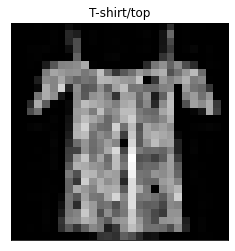

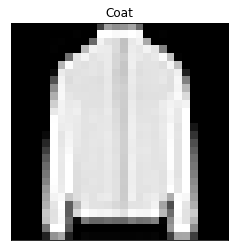

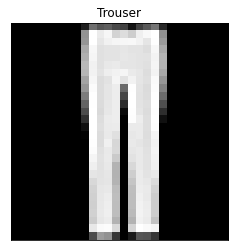

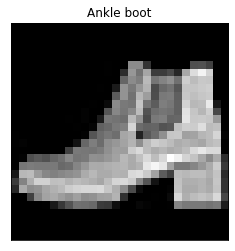

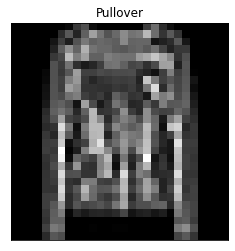

In [17]:
index = list(np.linspace(0, len(xtest_raw), len(xtest_raw), dtype=np.int32))
for i in sample(index, 5):
    predictions(xtest_nor, i, p_nor)